In [54]:
import random
import torch
import sys
import numpy as np
import math
import matplotlib.pyplot as plt
import scipy.io as sio
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt

from timeit import default_timer

sys.path.append('../')
from models import FNN_train, UnitGaussianNormalizer, LpLoss

# Load fracture problem dataset

A total of 181 samples are divided into 3 mat files. In this problem, we will be mapping the initial condition to the growth of the crack. 
The initial condition is phi(:,0) for all the samples. The space is defined using 34 x 34 x 34 points in space. The coordinates of these points are in "coordinates.mat".
The evolution is mapped using 16 steps which can be considered equally spaced between (0,1]. In each of the dataset.mat, you could take phi(:,0) as the initial condition and then map it to phi(:,1:end). The parameter phi denotes the crack evolution. In case we also want to do the elastic fields, we could map phi(:,0) \rightarraow [u(:,1:end), v(:,1:end), w(:,1:end), phi(:,1:end)].


In [21]:
pref = "/Users/huangdz/Desktop/FNO/FNO-cost-accuracy/"
dataset1 = sio.loadmat(pref + "dataset_uniform1.mat")
dataset2 = sio.loadmat(pref + "dataset_uniform2.mat")
dataset3 = sio.loadmat(pref + "dataset_uniform3.mat")

nq = 41
xx = np.linspace(-0.1, 0.1, nq)
yy = np.linspace(-0.1, 0.1, nq)
zz = np.linspace(-0.1, 0.1, nq)
[yq,xq,zq] = np.meshgrid(xx,yy,zz)


In [4]:
phi = np.vstack((dataset1["phi_uniform"], dataset2["phi_uniform"], dataset3["phi_uniform"]))
ndata = phi.shape[0]
T = 1.0
nt = phi.shape[2]
phi_data = phi.reshape((ndata, nq, nq, nq, nt), order="F")

coord_data  = np.zeros((nq, nq, nq, nt, 4),  dtype="float64")
for i in range(nt):
    coord_data[:,:,:,i,0] = xq
    coord_data[:,:,:,i,1] = yq
    coord_data[:,:,:,i,2] = zq
    coord_data[:,:,:,i,3] = i/nt * T
    
FNO_dim = 3
if FNO_dim == 3:
    input_data = np.concatenate((phi_data[:, :, :, :, 0:1], np.tile(coord_data[:, :, :, 0, 0:3], (ndata,1,1,1,1))), axis=-1)
    output_data = phi_data[:, :, :, :, nt-1:nt]
elif FNO_dim == 4:
    input_data = np.concatenate((np.tile(phi_data[:, :, :, :, 0:1], (1,1,1,1,nt-1))[..., np.newaxis], np.tile(coord_data[:, :, :, 1:nt, :], (ndata,1,1,1,1,1))), axis=-1)
    output_data = phi_data[:, :, :, :, 1:nt, np.newaxis]
  

# FNO training

In [5]:
torch.manual_seed(0)
np.random.seed(0)


n_train = 160
n_test = 21
x_train = torch.from_numpy(input_data[0:n_train, ...].astype(np.float32))
y_train = torch.from_numpy(output_data[0:n_train, ...].astype(np.float32))
x_test = torch.from_numpy(input_data[-n_test:, ...].astype(np.float32))
y_test = torch.from_numpy(output_data[-n_test:, ...].astype(np.float32))



In [6]:
n_fno_layers = 3
k_max = 12
d_f = 32
# fourier k_max
modes = [k_max] * n_fno_layers
modes4 = [6] * n_fno_layers
# channel d_f
layers = [d_f] * (n_fno_layers + 1)
fc_dim = d_f
in_dim = 1 + FNO_dim
out_dim = 1
act = "gelu"

base_lr = 0.001
epochs = 1000
# scheduler = "CosineAnnealingLR"
weight_decay = 1e-4

scheduler = "MultiStepLR"

pad_ratio = 0.05

milestones = [200, 300, 400, 500, 800, 900]
scheduler_gamma = 0.5
batch_size=2
normalization_x = True
normalization_y = True
normalization_dim = []


config = {"model" : {"modes": modes, "modes4": modes4, "fc_dim": fc_dim, "layers": layers, "in_dim": in_dim, "out_dim":out_dim, "act": act, "pad_ratio":pad_ratio},
          "train" : {"base_lr": base_lr, "weight_decay": weight_decay, "epochs": epochs, "scheduler": scheduler, "milestones": milestones, "scheduler_gamma": scheduler_gamma, "batch_size": batch_size, 
                    "normalization_x": normalization_x,"normalization_y": normalization_y, "normalization_dim": normalization_dim}}




In [10]:
start = default_timer()
train_rel_l2_losses, test_rel_l2_losses, test_l2_losses, cost = FNN_train(x_train, y_train, x_test, y_test, config, save_model_name="models/FNO_crack_dim"+str(FNO_dim))
end = default_timer()
print("epochs = ", epochs, "elapsed time = ", end - start)

Epoch :  0  Rel. Train L2 Loss :  0.3058393567800522  Rel. Test L2 Loss :  0.1575937093723388  Test L2 Loss :  0.028227337325612705


KeyboardInterrupt: 

# Visualization

torch.Size([1, 41, 41, 41, 1]) torch.Size([1, 41, 41, 41, 1])
 test_ind =  3 ; rel_l2 err =  0.15504801273345947


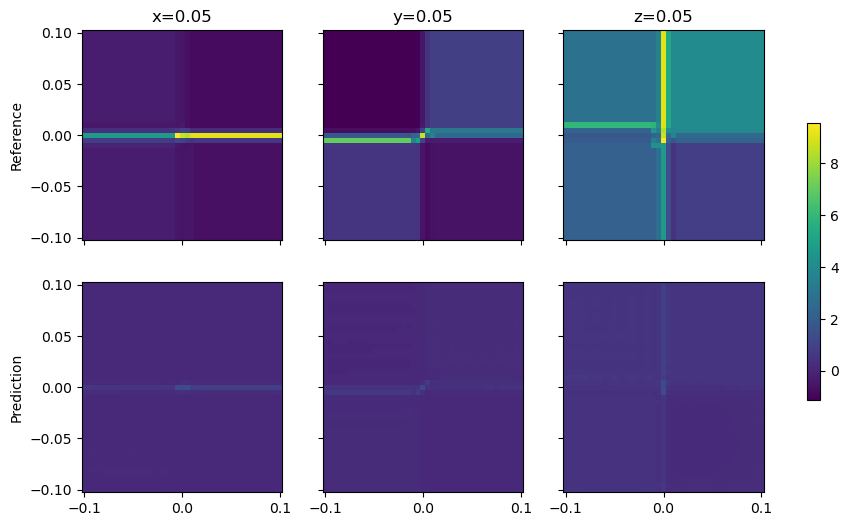

In [53]:
def validation(x_train, y_train, x_test, y_test, config, test_ind, test_nt=-1):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    normalization_x, normalization_y, normalization_dim = config["train"]["normalization_x"], config["train"]["normalization_y"], config["train"]["normalization_dim"]
    dim = len(x_train.shape) - 2
    n_data = x_train.shape[0]
    
    model = torch.load("models/FNO_crack_dim"+str(dim), map_location=device)
    
    
    if normalization_x:
        x_normalizer = UnitGaussianNormalizer(x_train, dim=normalization_dim)
        x_train = x_normalizer.encode(x_train)
        x_test = x_normalizer.encode(x_test)
        x_normalizer.to(device)
        
        
    if normalization_y:
        y_normalizer = UnitGaussianNormalizer(y_train, dim=normalization_dim)
        y_train = y_normalizer.encode(y_train)
        y_test = y_normalizer.encode(y_test)
        y_normalizer.to(device)

    
    x, y = x_test[test_ind:test_ind+1,...], y_test[test_ind:test_ind+1,...]
    x, y = x.to(device), y.to(device)
    out = model(x) #.reshape(1,  -1)

    
    if normalization_y:
        out = y_normalizer.decode(out)
        y = y_normalizer.decode(y)
    
    
    myloss = LpLoss(d=1, p=2, size_average=False)
    print(out.shape, y.shape)
    test_rel_l2 = myloss(out.reshape(1,-1), y.reshape(1,-1)).item()
    print(" test_ind = ",  test_ind,  "; rel_l2 err = ", test_rel_l2)
    
    if dim == 3:
        y_ref = y_test[test_ind,:,:,:,0].numpy()
        y_pred = out[0,:,:,:,0].detach().numpy()
    else:
        y_ref = y_test[test_ind,:,:,:,test_nt,0].numpy()
        y_pred = out[0,:,:,:,test_nt,0].detach().numpy()
    
    
    fig, axis = plt.subplots(2, 3, figsize = (11, 6), sharex=True, sharey=True)   # first row: reference; second row: prediction
    nq = 41
    xx = np.linspace(-0.1, 0.1, nq)
    yy = np.linspace(-0.1, 0.1, nq)
    zz = np.linspace(-0.1, 0.1, nq)
    [yq,xq,zq] = np.meshgrid(xx,yy,zz)
    
    slice_ind = 20
    vmin = min(y_ref[slice_ind,:,:].min(), y_ref[:,slice_ind,:].min(), y_ref[:,:,slice_ind].min())
    vmax = max(y_ref[slice_ind,:,:].max(), y_ref[:,slice_ind,:].max(), y_ref[:,:,slice_ind].max())
    
    pcm = axis[0, 0].pcolormesh(yq[slice_ind,:,:],zq[slice_ind,:,:], y_ref[slice_ind,:,:], vmin=vmin, vmax=vmax) 
    axis[0, 0].set_title("x=0.05")
    axis[0, 0].set_ylabel("Reference")
    axis[0, 1].pcolormesh(xq[:,slice_ind,:],zq[:,slice_ind,:], y_ref[:,slice_ind,:], vmin=vmin, vmax=vmax) 
    axis[0, 1].set_title("y=0.05")
    axis[0, 2].pcolormesh(xq[:,:,slice_ind],yq[:,:,slice_ind], y_ref[:,:,slice_ind], vmin=vmin, vmax=vmax) 
    axis[0, 2].set_title("z=0.05")
    axis[1, 0].pcolormesh(yq[slice_ind,:,:],zq[slice_ind,:,:], y_pred[slice_ind,:,:], vmin=vmin, vmax=vmax) 
    axis[1, 0].set_ylabel("Prediction")
    axis[1, 1].pcolormesh(xq[:,slice_ind,:],zq[:,slice_ind,:], y_pred[:,slice_ind,:], vmin=vmin, vmax=vmax) 
    axis[1, 2].pcolormesh(xq[:,:,slice_ind],yq[:,:,slice_ind], y_pred[:,:,slice_ind], vmin=vmin, vmax=vmax)
    fig.colorbar(pcm, ax=axis, shrink=0.6)
        
    fig.savefig("crack_dim_"+str(dim)+"_testid_"+str(test_ind)+"_nt_"+str(test_nt)+".pdf")
    return 
             

    
    
# validation(x_train, y_train, x_test, y_test, config, test_ind=3, test_nt=-1)


In [12]:
y_test_numpy.shape

(21, 41, 41, 41, 1)